In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller, kpss

import pmdarima as pm
import yfinance as yf

In [2]:
import sys
sys.path.append('..')
sys.path.append('../utils')

In [3]:
from sdafe.plot import plot_qq_norm
from sdafe.r import tl, fv, el
from ch14.utils import plot_residuals

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

In [5]:
rugarch = importr('rugarch')
rmethods = importr('methods')
rstats = importr('stats')
MTS = importr('MTS')

#### Exercise 1

$$
E[|Z|] 
= \int_{-\infty}^\infty \frac{1}{\sqrt{2\pi}} |z| e^{-z^2/2} dz 
= 2 \int_0^\infty \frac{1}{\sqrt{2\pi}} z e^{-z^2/2} dz 
= \frac{1}{\sqrt{2\pi}} \int_0^\infty e^{-z^2/2} d(z^2)
= \frac{1}{\sqrt{2\pi}} \int_0^\infty e^{-y/2} dy
= -\frac{2}{\sqrt{2\pi}} \left .e^{-y/2} \right|_0^\infty
= \sqrt{\frac{2}{\pi}}.
$$

#### Exercise 2

Given
$$f_X(x) =
\begin{cases}
\frac14, &\text{if }|x| < 1 \\
\frac{1}{4x^2}, &\text{if }|x| \geq 1
\end{cases}$$

$$
\int_{-\infty}^{+\infty} f_X(x) dx = \int_{-\infty}^{-1} \frac{1}{4x^2} dx + \int_{-1}^{1} \frac{1}{4} dx + \int_{1}^{+\infty} \frac{1}{4x^2} dx
= - \left. \frac{1}{4x} \right|_{-\infty}^{-1} + \left. \frac{x}{4} \right|_{-1}^{1} - \left. \frac{1}{4x} \right|_{-1}^{+\infty} = \frac14 + 0 + \frac14 + \frac14 - 0 + \frac14 = 1.
$$

But then
$$\int_{-\infty}^0 x f_X(x) dx = \int_{-\infty}^{-1} \frac{x}{4x^2} dx + \int_{-1}^0 \frac{x}{4} dx = \left. \log|x| \right|_{-\infty}^{-1} + \left. \frac{x^2}{8} \right|_{-1}^0 = -\infty$$
and similarly
$$\int_0^{\infty} x f_X(x) dx = \int_0^1 \frac{x}{4} dx + \int_1^\infty \frac{x}{4x^2} dx = \left. \frac{x^2}{8} \right|_0^1 + \left. \log |x| \right|_1^\infty = +\infty,$$
so $E[X]$ does not exist.

#### Exercise 3

In [6]:
mu = 3
phi = 0.72
omega = 1
alpha = 0.35

First, recall that if $X$ is independent of $Y$, then $E[XY] = E[X]E[Y]$:
$$
E[XY] = \int_{-\infty}^{\infty} xy f_{XY}(x, y) dx dy = \int_{-\infty}^{\infty} xy f_{X}(x) f_Y(y) dx dy = \int_{-\infty}^{\infty} x f_X(x) dx \int_{-\infty}^{\infty} y f_{Y}(y) dy = E[X] E[Y].
$$

Then if $X$ is independent of $Y$ and $Z$, then $\mathrm{Cov}[XY,Z] = E[X] \mathrm{Cov}[Y,Z]$:
$$
\mathrm{Cov}[XY,Z] = E[XYZ] - E[XY] E[Z] = E[X]E[YZ] - E[X] E[Y] E[Z] = E[X] (E[YZ]-E[Y]E[Z]) = E[X] \mathrm{Cov}[Y, Z].
$$

We consider the general case
$$
\begin{equation}
\begin{split}
a_t &=& \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2} \\
y_t &=& \mu + \phi y_{t-1} + a_t
\end{split}
\end{equation}
$$

Given $\epsilon_t$ are i.i.d. $N(0, 1)$, we have 
$$
\begin{equation}
\begin{split}
& E[\epsilon_t] &=& 0 \\
& \mathrm{Var}[\epsilon_t] &=& 1 \\
& E[\epsilon_t^2] &=& \mathrm{Var}[\epsilon_t] + E^2[\epsilon_t] = 1
\end{split}
\end{equation}
$$


First, consider $a_t$. Since $\epsilon_t$ and $a_{t-1}$ are independent, we have
$$
E[a_t] = E\left[\epsilon_t \sqrt{\omega + \alpha a_{t-1}^2}\right] = E[\epsilon_t] E\left[\sqrt{\omega + \alpha a_{t-1}^2}\right] = 0 \cdot E\left[\sqrt{\omega + \alpha a_{t-1}^2}\right] = 0.
$$

For $a_t^2$:
$$
E[a_t^2] = E\left[\epsilon_t^2 (\omega + \alpha a_{t-1}^2)\right] = E[\epsilon_t^2] E[\omega + \alpha a_{t-1}^2] = \omega + \alpha E[a_{t-1}^2].
$$
Assuming that the time series is stationary gives us $E[a_t^2] = E[a_{t-1}^2]$, hence
$$
E[a_t^2] = \frac{\omega}{1 - \alpha}.
$$

Then
$$
\mathrm{Var}[a_t] = E[a_t^2] - E^2[a_t] = E[\epsilon_t^2 (\omega + \alpha a_{t-1}^2)] = E[\epsilon_t^2] (\omega + \alpha E[a_{t-1}^2]) = \left(\omega + \alpha \frac{\omega}{1 - \alpha}\right) = \frac{\omega}{1-\alpha}.
$$

$$
\mathrm{Cov}[a_t, a_{t-h}] = \mathrm{Cov}\left[\epsilon_t \sqrt{\omega + \alpha a_{t-1}^2}, a_{t-h}\right] = E[\epsilon_t] \mathrm{Cov}\left[\sqrt{\omega + \alpha a_{t-1}^2}, a_{t-h}\right] = 0,
$$
so
$$
\rho_{a_t}(h) = 
\begin{cases}
1, &\text{if }h = 0 \\
0, &\text{if }h \neq 0
\end{cases}
$$




(a)
$$
E[y_t] = E[\mu + \phi y_{t-1} + a_t] = \mu + \phi E[y_{t-1}] + E[a_t] = \mu + \phi E[y_{t-1}],
$$
where we used $E[a_t] = 0$ from above.
Assuming stationarity, we get
$$
E[y_t] = \frac{\mu}{1-\phi}.
$$

In [7]:
mu / (1 - phi)

10.714285714285714

(b)
$$
\mathrm{Var}[y_t] 
= \mathrm{Var}[\mu + \phi y_{t-1} + a_t] 
= \phi^2 \mathrm{Var}[y_{t-1}] + \mathrm{Var}[a_t] + 2 \mathrm{Cov}[y_{t-1}, a_t]
= \phi^2 \mathrm{Var}[y_{t-1}] + \frac{\omega}{1-\alpha} + 2 \mathrm{Cov}\left[y_{t-1}, \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2}\right]
= \phi^2 \mathrm{Var}[y_{t-1}] + \frac{\omega}{1-\alpha},
$$
where we used the fact that $\epsilon_t$ is independent of both $y_{t-1}$ and $\sqrt{\omega + \alpha a_{t-1}^2}$ and therefore
$$
\mathrm{Cov}\left[y_{t-1}, \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2}\right] = E[\epsilon_t] \mathrm{Cov}\left[y_{t-1}, \sqrt{\omega + \alpha a_{t-1}^2}\right] = 0 \cdot \mathrm{Cov}\left[y_{t-1}, \sqrt{\omega + \alpha a_{t-1}^2}\right] = 0.
$$

In the stationary case $\mathrm{Var}[y_t] = \mathrm{Var}[y_{t-1}]$ and so
$$
\mathrm{Var}[y_t] = \frac{\omega}{(1-\alpha)(1-\phi^2)}.
$$

In [8]:
omega / (1 - alpha) / (1 - phi ** 2)

3.194479938665985

(c)
If $h>0$,
$$
\mathrm{Cov}[y_t, y_{t-h}]
= \mathrm{Cov}[\mu + \phi y_{t-1} + a_t, y_{t-h}]
= \mathrm{Cov}\left[\mu + \phi y_{t-1} + \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2}, y_{t-h}\right]
= \phi \mathrm{Cov}[y_{t-1}, y_{t-h}] + \mathrm{Cov}\left[\epsilon_t \sqrt{\omega + \alpha a_{t-1}^2}, y_{t-h}\right],
= \phi \mathrm{Cov}[y_{t-1}, y_{t-h}]
= \phi \mathrm{Cov}[y_t, y_{t-(h-1)}]
= \phi^h \mathrm{Var}[y_t].
$$
If $h<0$,
$$
\mathrm{Cov}[y_t, y_{t-h}] = \mathrm{Cov}[y_{t-h}, y_t] = \mathrm{Cov}[y_t, y_{t+h}] = \phi^{-h} \mathrm{Var}[y_t],
$$
and if $h=0$,
$$
\mathrm{Cov}[y_t, y_t] = \phi^0 \mathrm{Var}[y_t],
$$
so we obtain for all values of $h$
$$
\mathrm{Cov}[y_t, y_{t-h}] = \phi^{|h|} \mathrm{Var}[y_t].
$$

The auto-correlation function is therefore
$$\rho_{y_t}(h) = \frac{\mathrm{Cov}[y_t, y_{t-h}]}{\sqrt{\mathrm{Var}[y_t] \mathrm{Var}[y_{t-h}]}} = \frac{\mathrm{Cov}[y_t, y_{t-h}]}{\mathrm{Var}[y_t]} = \phi^{|h|}.$$

(d)

If $h>0$,
$$
\mathrm{Cov}[a_t^2, a_{t-h}^2]
= \mathrm{Cov}[\epsilon_t^2 (\omega + \alpha a_{t-1}^2), a_{t-h}^2]
= E[\epsilon_t^2] \mathrm{Cov}[\omega + \alpha a_{t-1}^2, a_{t-h}^2]
= \alpha \mathrm{Cov}[a_{t-1}^2, a_{t-h}^2]
= \alpha \mathrm{Cov}[a_t^2, a_{t-(h-1)}^2]
= \alpha^h \mathrm{Var}[a_t^2],
$$
and using the similar logic as for $\mathrm{Cov}[y_t, y_{t-h}]$, we obtain
$$\rho_{a_t^2}(h) = \alpha^{|h|}.$$

#### Exercise 4

In [9]:
mu = 0.4
phi = 0.45
omega = 1
alpha = 0.3
y1 = 1
y0 = 0.2

(a)

$$E[y_2|y_1,y_0] = E[\mu + \phi (y_1 - \mu) + a_2|y_1, y_0] = \mu + \phi(y_1 - \mu)$$

In [10]:
mu + phi * (y1 - mu)

0.67

(b)
Given $y_0$ and $y_1$, we have
$$y_1 - \mu = \phi (y_0 - \mu) + a_1,$$
from which
$$a_1 = y_1 - \mu - \phi (y_0 - \mu).$$

Now
$$
\mathrm{Var}[y_2 | y_1, y_0]
= \mathrm{Var}[\mu + \phi(y_1 - \mu) + a_2 | y_1, y_0]
= \mathrm{Var}[a_2 | y_1, y_0] 
= \mathrm{Var}[\epsilon_2 \sqrt{\omega + \alpha a_1^2} | y_1, y_0] \\
= \mathrm{Var}[\epsilon_2 \sqrt{\omega + \alpha (y_1 - \mu - \phi (y_0 - \mu))^2} | y_1, y_0]
= (\omega + \alpha (y_1 - \mu - \phi (y_0 - \mu))^2) \mathrm{Var}[\epsilon_2 | y_1, y_0]
= \omega + \alpha (y_1 - \mu - \phi (y_0 - \mu))^2
$$



In [11]:
omega + alpha * (y1 - mu - phi * (y0 - mu)) ** 2

1.14283

#### Exercise 5

In [12]:
mu = 2
phi = 0.67
omega = 7
alpha = 0.5

Using the results of Exercise 3:

(a)

In [13]:
mu / (1 - phi)

6.060606060606061

(b) $\rho_{y_t}(h) = \phi^{|h|} = 0.67^{|h|}$

(c)

$$
\rho_{a_t}(h) = 
\begin{cases}
1, &\text{if }h = 0 \\
0, &\text{if }h \neq 0
\end{cases}
$$

(d)

$$\rho_{a_t^2}(h) = \alpha^{|h|} = 0.5^{|h|}$$

#### Exercise 6

In [14]:
beta0 = 0.06
beta1 = 0.35
delta = 0.22
omega = 1
alpha = 0.5
Xt = 0.1
atm1 = 0.6

(a)

$$
E[Y_t | X_t, a_{t-1}] 
= E[\beta_0 + \beta_1 X_t + \delta \sigma_t + a_t | X_t, a_{t-1}] 
= E\left[\beta_0 + \beta_1 X_t + \delta \sqrt{\omega + \alpha a_{t-1}^2} + \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2} | X_t, a_{t-1}\right]
= \beta_0 + \beta_1 X_t + \delta \sqrt{\omega + \alpha a_{t-1}^2} + \sqrt{\omega + \alpha a_{t-1}^2} E\left[\epsilon_t | X_t, a_{t-1}\right]
= \beta_0 + \beta_1 X_t + \delta \sqrt{\omega + \alpha a_{t-1}^2}.
$$

In [15]:
beta0 + beta1 * Xt + delta * np.sqrt(omega + alpha * atm1 ** 2)

0.3339811708064047

(b)
$$
\mathrm{Var}[Y_t|X_t, a_{t-1}]
= \mathrm{Var}[\beta_0 + \beta_1 X_t + \delta \sigma_t + a_t | X_t, a_{t-1}]
= \mathrm{Var}\left[\beta_0 + \beta_1 X_t + \delta \sqrt{\omega + \alpha a_{t-1}^2} + \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2} | X_t, a_{t-1}\right]
= (\omega + \alpha a_{t-1}^2) \mathrm{Var}[\epsilon_t|X_t, a_{t-1}]
= \omega + \alpha a_{t-1}^2.
$$

In [16]:
omega + alpha * atm1 ** 2

1.18

(c) Given $X_t$ and $a_{t_1}$,
$$
Y_t = \beta_0 + \beta_1 X_t + \delta \sigma_t + a_t = \beta_0 + \beta_1 X_t + \delta \sqrt{\omega + \alpha a_{t-1}^2} + \epsilon_t \sqrt{\omega + \alpha a_{t-1}^2} = a + b \epsilon_t,
$$
where $a=\beta_0 + \beta_1 X_t + \delta \sqrt{\omega + \alpha a_{t-1}^2}$ and $b=\sqrt{\omega + \alpha a_{t-1}^2}$ are constants. Therefore, $Y_t|X_t,a_{t-1}$ is normally distributed.

(d) The marginal distribution of $Y_t$ depends on the distribution of $X_t$, so in the general case is not normal. It also depends non-linearly on $\epsilon_{t-1}, \epsilon_{t-2}, ...$.

#### Exercise 7

(a) $a_t$ is an ARCH(1) process.

(b) $y_t$ is an AR(1)+ARCH(1) process.

(c) The distribution of $a_t$ is not Gaussian and has heavier than Gausian tails.

In [17]:
n = 1000000
t = 100
alpha = 0.3
omega = 2
eps = stats.norm.rvs(size=(n, t))
sigma = np.sqrt(1 + np.sum(np.cumprod(eps[:, 1:] ** 2, axis=1) * alpha ** np.arange(1, t), axis=1))
a = sigma * eps[:, 0] * np.sqrt(omega)

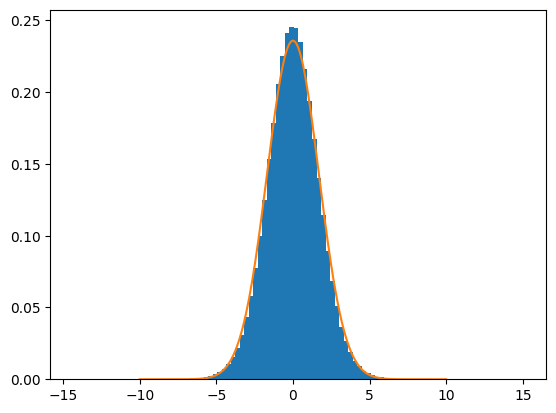

In [18]:
xs = np.linspace(-10, 10, 200)

fig, ax = plt.subplots()
ax.hist(a, bins=100, density=True);
ax.plot(xs, stats.norm.pdf(xs, loc=np.mean(a), scale=np.std(a, ddof=1)));

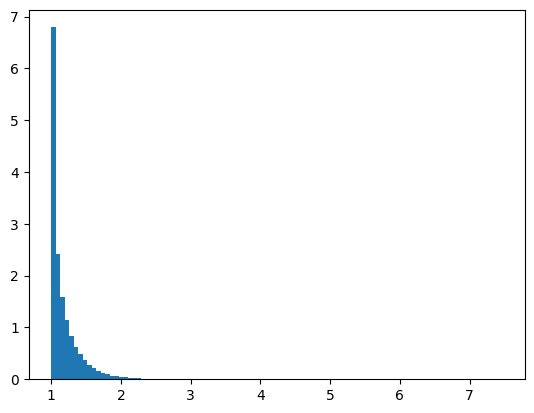

In [19]:
fig, ax = plt.subplots()
ax.hist(sigma, bins=100, density=True);

(d-f) The formulas are given in the answer to Exercise 3.

#### Exercise 8

In [20]:
data = pd.read_csv('../data/SP500.csv')
data.head()

,r500
0,-0.011727
1,0.002454
2,0.011052
3,0.019051
4,-0.005566


In [21]:
ret_bl_mon = data.iloc[1804, 0]

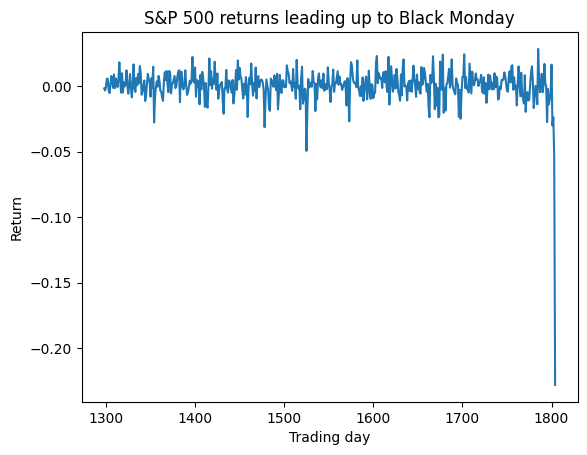

In [22]:
fig, ax = plt.subplots()
ax.plot(data.iloc[1804 - 2 * 253: 1805]);
ax.set_title('S&P 500 returns leading up to Black Monday');
ax.set_xlabel('Trading day');
ax.set_ylabel('Return');

In [23]:
x = data.iloc[1804 - 2 * 253: 1804]

In [24]:
spec = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(1, 0)}), variance_model=tl({'garchOrder': fv(1, 1)}), distribution_model='std')
with np_cv_rules.context():
    fit = rugarch.ugarchfit(data=x.values, spec=spec)
    forecast = rugarch.ugarchforecast(fit, data=x.values, n_ahead=1)
rmethods.show(fit);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.001338    0.000398 3.3595e+00 0.000781
ar1     0.086344    0.039644 2.1780e+00 0.029408
omega   0.000000    0.000000 1.3715e+00 0.170215
alpha1  0.000004    0.000211 1.9582e-02 0.984377
beta1   0.998995    0.000436 2.2932e+03 0.000000
shape   3.291722    0.332088 9.9122e+00 0.000000

Robust Standard Errors:
        Estimate  Std. Error    t value Pr(>|t|)
mu      0.001338    0.000334   4.009442 0.000061
ar1     0.086344    0.043288   1.994667 0.046079
omega   0.000000    0.000001   0.301688 0.762890
alpha1  0.000004    0.011342   0.000364 0.999710
beta1   0.998995    0.007911 126.285437 0.000000
shape   3.291722    1.125585  

(a) 

In [25]:
df_hat = el(fit.slots['fit'], 'coef')[5]
r_hat = el(forecast.slots['forecast'], 'seriesFor')[0]
sigma_hat = el(forecast.slots['forecast'], 'sigmaFor')[0]

In [26]:
stats.t.cdf(ret_bl_mon, loc=r_hat, scale=sigma_hat, df=df_hat)

9.403944889758784e-05

(b)

In [27]:
with np_cv_rules.context():
    res = pd.Series(fit.slots['fit']['residuals'], index=x.index)
    res_std = res / fit.slots['fit']['sigma']

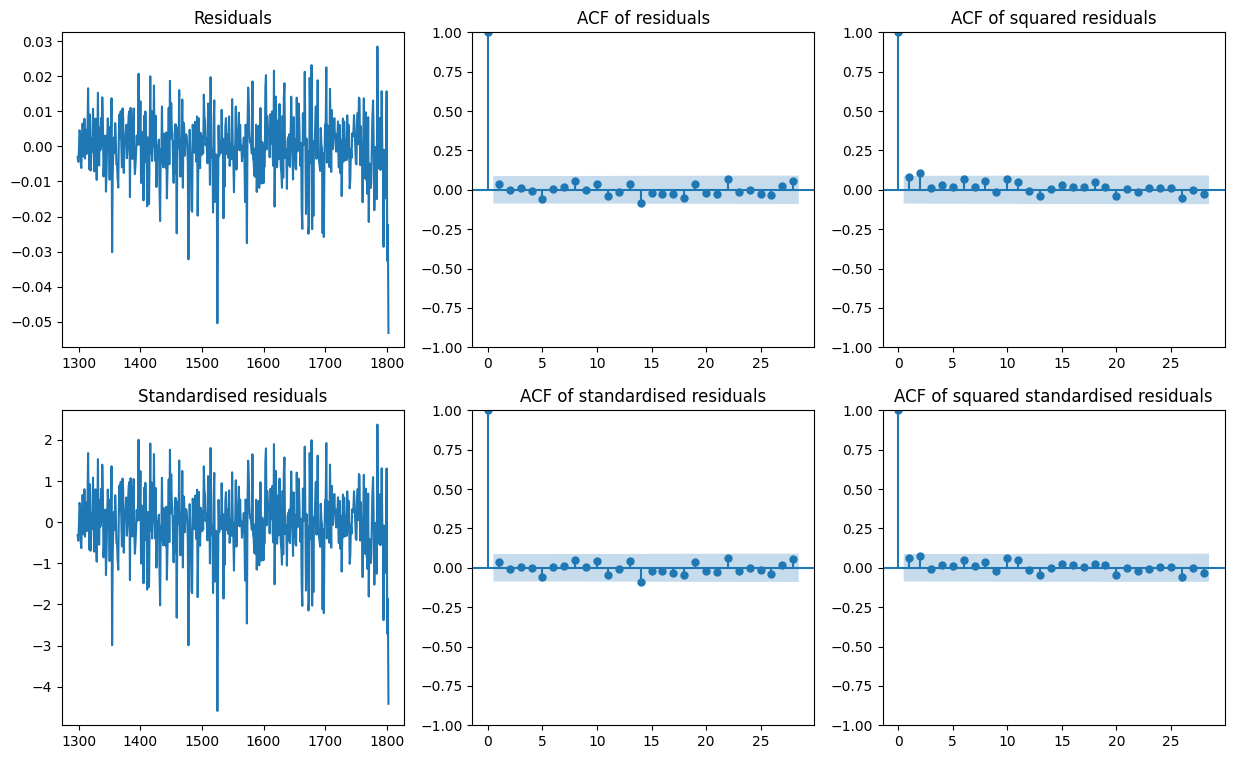

In [28]:
plot_residuals(res, res_std)

The plots indicate that the AR(1)+GARCH(1, 1) model fits the data adequately.

(c) An AR(1)+ARCH(1) model is unlikely to provide a good fit, since the `alpha1` coefficient in the GARCH model above is not significant, whereas `beta1` is highly significant.

In [29]:
spec2 = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(1, 0)}), variance_model=tl({'garchOrder': fv(1, 0)}), distribution_model='std')
with np_cv_rules.context():
    fit2 = rugarch.ugarchfit(data=x.values, spec=spec2)
    res2 = pd.Series(fit2.slots['fit']['residuals'], index=x.index)
    res_std2 = res2 / fit2.slots['fit']['sigma']
rmethods.show(fit2);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001370    0.000405   3.3807 0.000723
ar1     0.079859    0.041626   1.9185 0.055051
omega   0.000097    0.000015   6.3027 0.000000
alpha1  0.048544    0.055001   0.8826 0.377453
shape   3.933977    0.809730   4.8584 0.000001

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001370    0.000349  3.92555 0.000087
ar1     0.079859    0.033164  2.40800 0.016040
omega   0.000097    0.000014  6.92150 0.000000
alpha1  0.048544    0.058907  0.82407 0.409897
shape   3.933977    0.723970  5.43390 0.000000

LogLikelihood : 1653.969 

Information Criteria
------------------------------------
                 

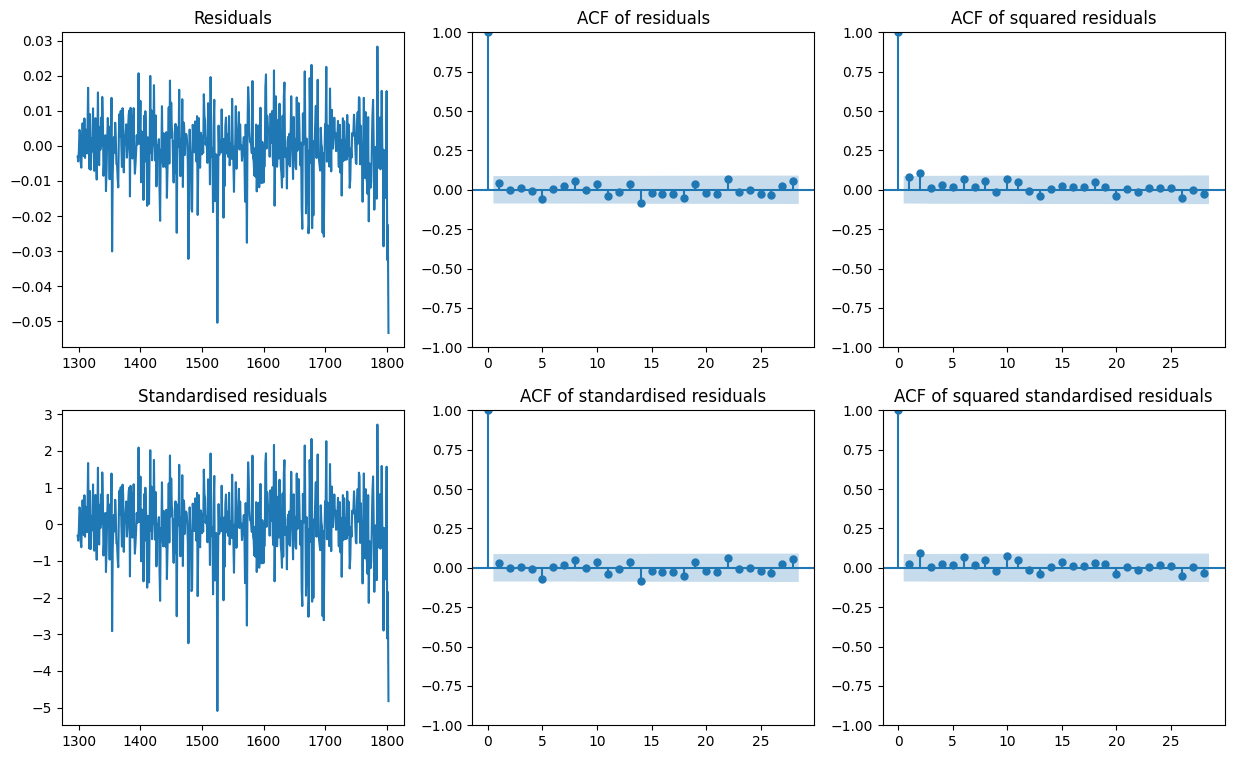

In [30]:
plot_residuals(res2, res_std2)

From the residual plots, we cannot conclude that this fit is worse than AR(1)+GARCH(1, 1). The autocorrelation of squared standardised residuals at lag two appears to be more significant in this case.

(d)

In [31]:
fit3 = sm.tsa.arima.ARIMA(x, order=(1, 0, 0)).fit(method='innovations_mle')
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   r500   No. Observations:                  506
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1626.515
Date:                Tue, 13 Jun 2023   AIC                          -3247.031
Time:                        13:14:50   BIC                          -3234.351
Sample:                             0   HQIC                         -3242.058
                                - 506                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.478      0.139      -0.000       0.002
ar.L1          0.1276      0.040      3.205      0.001       0.050       0.206
sigma2      9.451e-05   4.05e-06     23.344      0.000    8.66e-05       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               261.10
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

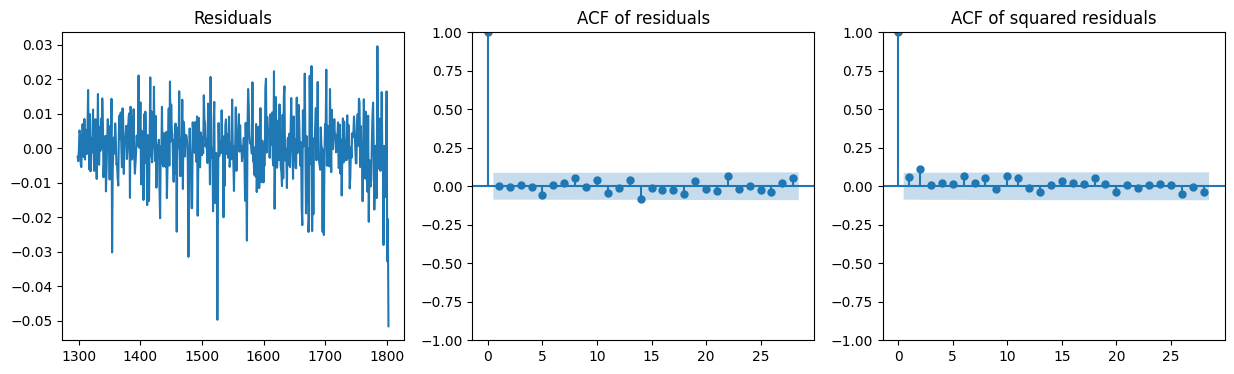

In [32]:
plot_residuals(fit3.resid)

It is again difficult to make conclusions about the adequacy of the model from the plots, however we see that the autocorrelation of squared residuals at lag 2 becomes even more prominent.

#### Exercise 9

In [33]:
data = pd.read_csv('../data/Irates.csv', index_col=0)
data.head()

,r1,r2,r3,r5,r6,r11,r12,r36,r60,r120
Year,,,,,,,,,,
1946.916667,0.325,0.422,0.477,0.549,0.577,0.698,0.720,1.145,1.415,1.825
1947.000000,0.322,0.427,0.485,0.555,0.583,0.698,0.718,1.119,1.386,1.824
1947.083333,0.326,0.419,0.473,0.543,0.571,0.693,0.715,1.140,1.406,1.817
1947.166667,0.318,0.441,0.508,0.583,0.610,0.718,0.737,1.105,1.364,1.804
1947.250000,0.302,0.445,0.521,0.606,0.637,0.759,0.780,1.172,1.416,1.815


In [34]:
r = np.log(data['r2'])
diffr = r.diff().dropna()

In [35]:
spec = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(1, 0)}), variance_model=tl({'garchOrder': fv(1, 1)}), distribution_model='std')
with np_cv_rules.context():
    fit = rugarch.ugarchfit(data=diffr.values, spec=spec)
    res = pd.Series(fit.slots['fit']['residuals'], index=diffr.index)
    res_std = res / fit.slots['fit']['sigma']
rmethods.show(fit);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.010084    0.002587   3.8979 0.000097
ar1     0.095981    0.043276   2.2179 0.026564
omega   0.000503    0.000236   2.1312 0.033076
alpha1  0.254352    0.080236   3.1701 0.001524
beta1   0.744648    0.063585  11.7111 0.000000
shape   3.102612    0.404823   7.6641 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.010084    0.003054   3.3015 0.000962
ar1     0.095981    0.042365   2.2656 0.023478
omega   0.000503    0.000323   1.5584 0.119140
alpha1  0.254352    0.088632   2.8698 0.004108
beta1   0.744648    0.085187   8.7414 0.000000
shape   3.102612    0.397731   7.8008 0.000000

LogLikel

(a) The model used is AR(1)+GARCH(1, 1) with t-distributed innovations.

(b) The estimates of the parameters are:
| Parameter | Estimate |
|-----------|----------|
| mu        | 0.010084 |
| ar1       | 0.095981 |
| omega     | 0.000503 |
| alpha1    | 0.254352 |
| beta1     | 0.744648 |
| shape     | 3.102618 |

(c)

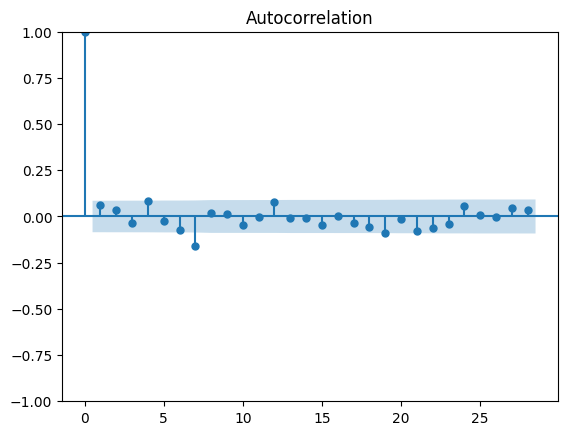

In [36]:
plot_acf(diffr);

(d)-(e)

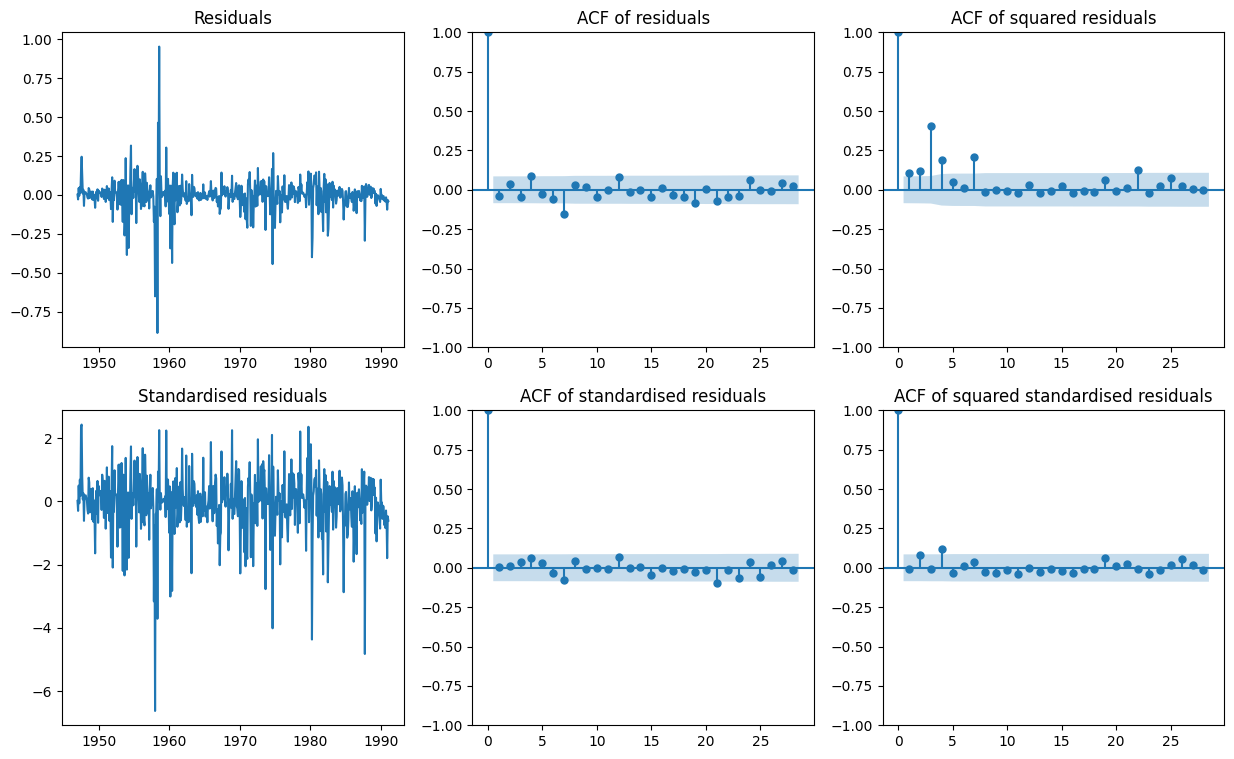

In [37]:
plot_residuals(res, res_std)

#### Exercise 10

In [38]:
data = yf.download("^GSPC", start="2005-01-01", end="2014-12-31")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1202.079956,1510800000
2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1188.050049,1721000000
2005-01-05,1188.050049,1192.729980,1183.719971,1183.739990,1183.739990,1738900000
2005-01-06,1183.739990,1191.630005,1183.270020,1187.890015,1187.890015,1569100000
2005-01-07,1187.890015,1192.199951,1182.160034,1186.189941,1186.189941,1477900000


In [39]:
sp500 = np.log(data['Adj Close']).diff().dropna()

(a)-(b) The ACF plots show significant serial correlations of log returns and very prominent autocorrelations of squared log returns suggesting strong conditional heteroskedasticity:

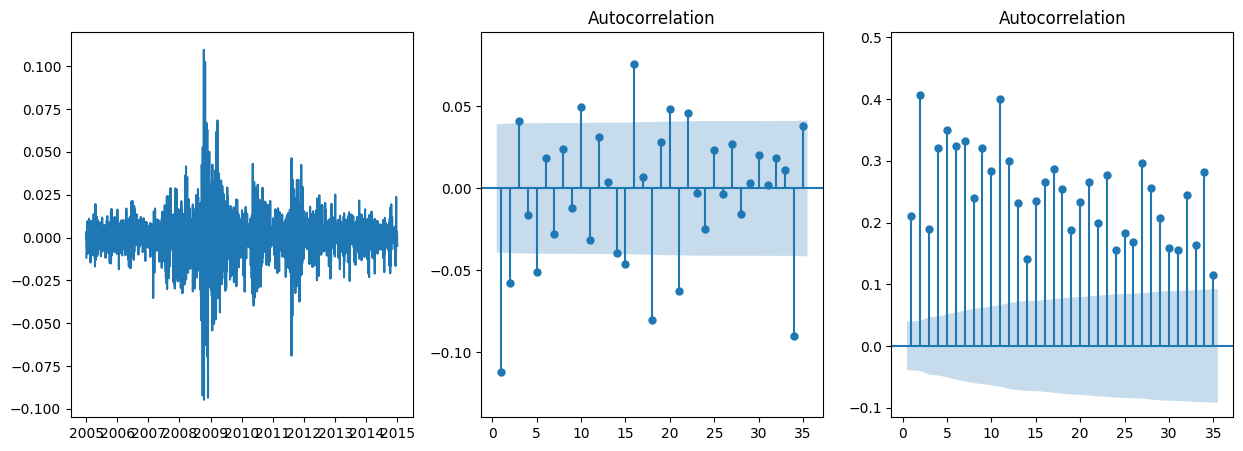

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(sp500);
plot_acf(sp500, ax=axs[1], zero=False, auto_ylims=True);
plot_acf(sp500 ** 2, ax=axs[2], zero=False, auto_ylims=True);

(c) First, we look for an ARIMA model that best accounts for serial correlations:

KPSS does not reject the null hypothesis of stationarity:

In [41]:
kpss(sp500, nlags=4, regression='c')  #  the parameters are set to match the behaviour in R

/tmp/ipykernel_169072/1709326970.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(sp500, nlags=4, regression='c')  #  the parameters are set to match the behaviour in R


(0.2045178362242152,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [42]:
fit = pm.auto_arima(sp500, information_criterion='bic', max_P=5, max_Q=5, max_order=10)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2515
Model:               SARIMAX(0, 0, 1)   Log Likelihood                7393.136
Date:                Tue, 13 Jun 2023   AIC                         -14782.272
Time:                        13:15:03   BIC                         -14770.612
Sample:                             0   HQIC                        -14778.040
                               - 2515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1175      0.011    -11.029      0.000      -0.138      -0.097
sigma2         0.0002   1.85e-06     88.333      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             12339.96
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.50
Prob(H) (two-sided):                  0.33   Kurtosis:                        13.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we use the selected model (MA(1)) to construct the MA(1)+ARCH(1) model:

In [43]:
spec = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(0, 1)}), variance_model=tl({'garchOrder': fv(1, 0)}))
with np_cv_rules.context():
    fit = rugarch.ugarchfit(data=sp500.values, spec=spec)
    res = pd.Series(fit.slots['fit']['residuals'], index=sp500.index)
    res_std = res / fit.slots['fit']['sigma']
rmethods.show(fit);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,0)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error   t value Pr(>|t|)
mu     -0.014845    0.000019   -800.06        0
ma1    -0.761138    0.000074 -10346.64        0
omega   0.000000    0.000001      0.00        1
alpha1  0.998534    0.022067     45.25        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.014845    0.044884 -0.33073  0.74085
ma1    -0.761138    0.547397 -1.39047  0.16439
omega   0.000000    0.003751  0.00000  1.00000
alpha1  0.998534    0.952907  1.04788  0.29469

LogLikelihood : 3039.821 

Information Criteria
------------------------------------
                    
Akaike       -2.4142
Bayes        -2.4049
Shibata      -2.4142
Hannan-Quinn -2.4108


The fitted model is as follows:
$$
\begin{equation}
\begin{split}
y_t &=& \mu + a_t + \theta a_{t-1} \\
a_t &=& \epsilon_t \sigma_t \\
\sigma_t &=& \sqrt{\omega + \alpha a_{t-1}^2}
\end{split}
\end{equation}
$$

(d) The fitted model is stationary, because $\alpha = 0.95 < 1$.

In [44]:
spec = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(0, 1)}), variance_model=tl({'garchOrder': fv(1, 1)}))
with np_cv_rules.context():
    fit = rugarch.ugarchfit(data=sp500.values, spec=spec)
    res = pd.Series(fit.slots['fit']['residuals'], index=sp500.index)
    sigma_proc = fit.slots['fit']['sigma']
    res_std = res / sigma_proc
rmethods.show(fit);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000599    0.000149   4.0282 0.000056
ma1    -0.070617    0.022162  -3.1863 0.001441
omega   0.000002    0.000001   2.0332 0.042036
alpha1  0.102140    0.012730   8.0233 0.000000
beta1   0.881530    0.013273  66.4174 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000599    0.000123  4.85799 0.000001
ma1    -0.070617    0.019343 -3.65080 0.000261
omega   0.000002    0.000006  0.35494 0.722637
alpha1  0.102140    0.040086  2.54801 0.010834
beta1   0.881530    0.052671 16.73650 0.000000

LogLikelihood : 8135.448 

Information Criteria
------------------------------------
                

The fitted model is as follows:
$$
\begin{equation}
\begin{split}
y_t &=& \mu + a_t + \theta a_{t-1} \\
a_t &=& \epsilon_t \sigma_t \\
\sigma_t &=& \sqrt{\omega + \alpha a_{t-1}^2 + \beta \sigma_{t-1}^2}
\end{split}
\end{equation}
$$

We check that the model does an acceptable job removing serial autocorrelations in residuals:

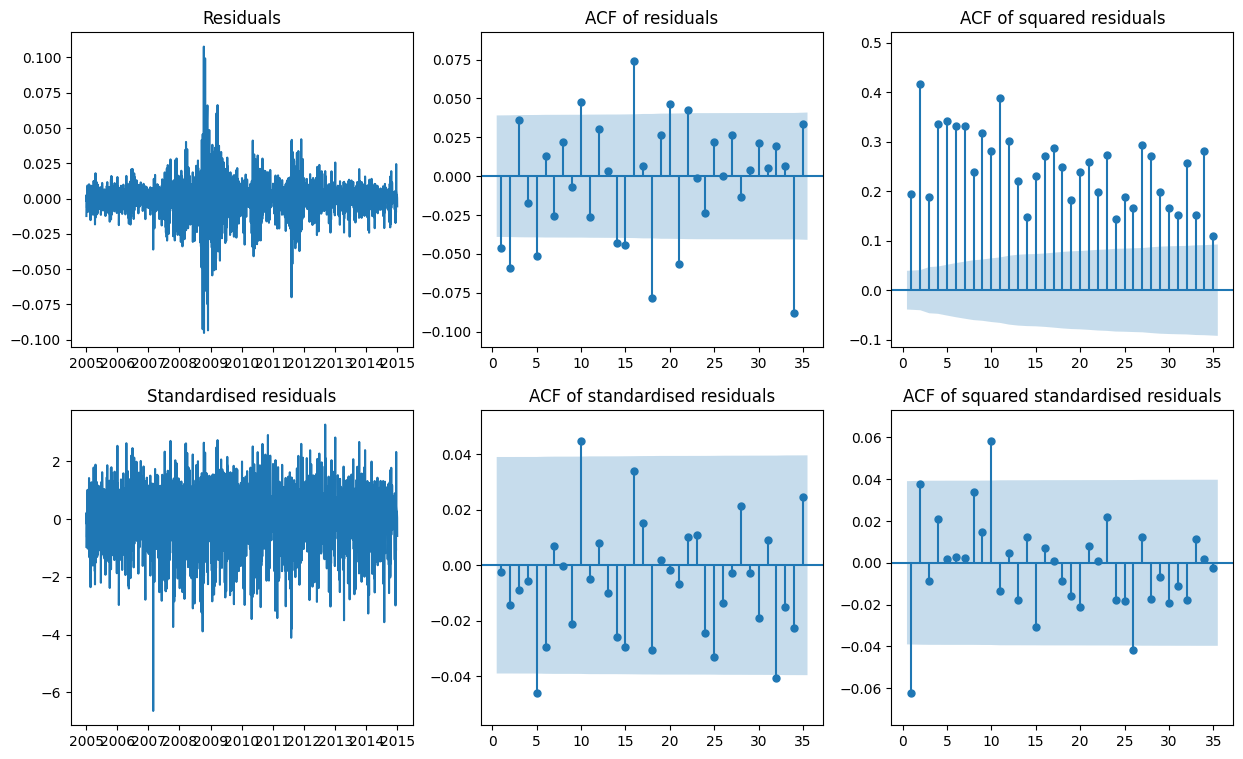

In [45]:
plot_residuals(res, res_std, zero=False)

(f)

For standardised squared residuals, we do not reject the null hypothesis of no serial autocorrelation:

In [46]:
with np_cv_rules.context():
    MTS.mq(res_std.values, lag=20)

Ljung-Box Statistics:  
          m       Q(m)     df    p-value
 [1,]  1.0000    0.0172  1.0000     0.90
 [2,]  2.0000    0.5482  2.0000     0.76
 [3,]  3.0000    0.7479  3.0000     0.86
 [4,]  4.0000    0.8269  4.0000     0.93
 [5,]  5.0000    6.2091  5.0000     0.29
 [6,]  6.0000    8.3856  6.0000     0.21
 [7,]  7.0000    8.5044  7.0000     0.29
 [8,]  8.0000    8.5045  8.0000     0.39
 [9,]  9.0000    9.6529  9.0000     0.38
[10,] 10.0000   14.7110 10.0000     0.14
[11,] 11.0000   14.7775 11.0000     0.19
[12,] 12.0000   14.9389 12.0000     0.24
[13,] 13.0000   15.1909 13.0000     0.30
[14,] 14.0000   16.8920 14.0000     0.26
[15,] 15.0000   19.1063 15.0000     0.21
[16,] 16.0000   22.0384 16.0000     0.14
[17,] 17.0000   22.6348 17.0000     0.16
[18,] 18.0000   25.0031 18.0000     0.12
[19,] 19.0000   25.0108 19.0000     0.16
[20,] 20.0000   25.0183 20.0000     0.20


For squared standardised residuals, the null hypothesis is rejected at 5%:

In [47]:
with np_cv_rules.context():
    MTS.mq(res_std.values ** 2, lag=20)

Ljung-Box Statistics:  
        m       Q(m)     df    p-value
 [1,]  1.00      9.75    1.00     0.00
 [2,]  2.00     13.30    2.00     0.00
 [3,]  3.00     13.49    3.00     0.00
 [4,]  4.00     14.60    4.00     0.01
 [5,]  5.00     14.61    5.00     0.01
 [6,]  6.00     14.62    6.00     0.02
 [7,]  7.00     14.64    7.00     0.04
 [8,]  8.00     17.50    8.00     0.03
 [9,]  9.00     18.04    9.00     0.03
[10,] 10.00     26.65   10.00     0.00
[11,] 11.00     27.12   11.00     0.00
[12,] 12.00     27.17   12.00     0.01
[13,] 13.00     27.98   13.00     0.01
[14,] 14.00     28.35   14.00     0.01
[15,] 15.00     30.77   15.00     0.01
[16,] 16.00     30.90   16.00     0.01
[17,] 17.00     30.90   17.00     0.02
[18,] 18.00     31.09   18.00     0.03
[19,] 19.00     31.73   19.00     0.03
[20,] 20.00     32.86   20.00     0.03


(g) The fitted model is stationary, since $\alpha + \beta = 0.98 < 1$, however it is close to non-stationarity.

(h)

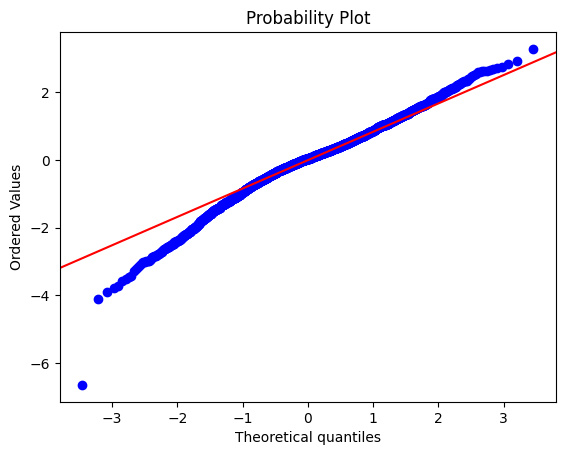

In [48]:
fig, ax = plt.subplots()
plot_qq_norm(ax, res_std);

The Gaussian distribution does not appear to be an adequate fit, as the empirical data has pronounced negative skewness:

In [49]:
stats.skew(sp500)

-0.334699600185478

(i) The plot of the fitted conditional standard deviation process $\sigma_t$ exhibits prolonged periods of persistent volatility:

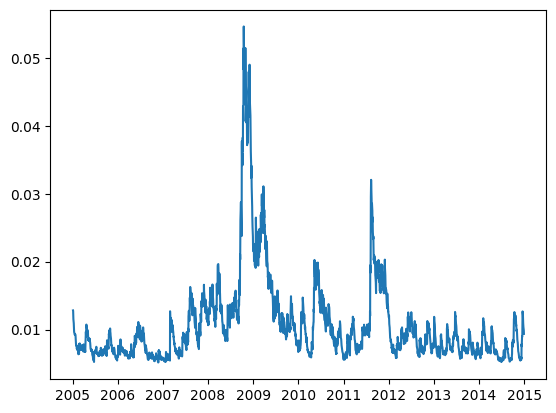

In [50]:
fig, ax = plt.subplots()
ax.plot(pd.Series(sigma_proc, index=sp500.index));